# Titanic Advanced Metrics Example
**Example by David Cochran**

Using the Titanic dataset from [this](https://www.kaggle.com/c/titanic/overview) Kaggle competition ...

1. Basic data prep
2. Split the data into Train (70%) / Test (30%)
3. Use GridSearch to train and tune models -- Logistic Regression and Random Forest.
4. Prioritizing ROC_AUC score, and then Recall -- creating specially tuned models for each.
3. Evaluate model performance on the test split, with confusion matrices and ROC curves.

References and Resources:
- [Churn Modeling Notebook by cutterback](https://github.com/cutterback/p03-telco-churn-model/blob/master/Telco-Churn-Classification-Model.ipynb)
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
- https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65


# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale = 1.1)
%matplotlib inline
from time import time

# Machine Learning Training, Scoring, and Metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import auc, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, plot_roc_curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, classification_report

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Data Preparation

In [2]:
df = pd.read_csv('data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Drop irrelevant columns
df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)

# Fill missing age values with average age
df['Age'].fillna(df['Age'].mean(), inplace = True)

# Create Family_count from SibSp and Parch
df['Family_count'] = df['SibSp'] + df['Parch']

# Drop SibSp and Parch
df.drop(['SibSp','Parch'], axis=1, inplace=True)

# Create Cabin_ind
df['Cabin_ind'] = np.where(df['Cabin'].isnull(), 0, 1)

# Drop Cabin and Embarked
df.drop(['Cabin','Embarked'], axis=1, inplace=True)

# Convert sex to numeric indicator
gender_map = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(gender_map)

# View Updated Dataframe Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    int64  
 3   Age           891 non-null    float64
 4   Fare          891 non-null    float64
 5   Family_count  891 non-null    int64  
 6   Cabin_ind     891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [5]:
# View first records
df.head()

,Survived,Pclass,Sex,Age,Fare,Family_count,Cabin_ind
0,0,3,0,22.0,7.2500,1,0
1,1,1,1,38.0,71.2833,1,1
2,1,3,1,26.0,7.9250,0,0
3,1,1,1,35.0,53.1000,1,1
4,0,3,0,35.0,8.0500,0,0


# ///////////////////////////////////////////////////

# Modeling & Eval Setup

# ///////////////////////////////////////////////////

In [6]:
# Specify random seed value to ensure results are reproducible
# See: https://towardsdatascience.com/how-to-use-random-seeds-effectively-54a4cd855a79
seed = 42

# Split into Train and Test Sets (70/30)
See the [train_test_split docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

- Train = 70%
- Validation = 30%

In [7]:
# All Features
all_features = df.drop('Survived', axis=1)

# All Labels
all_labels = df['Survived']

In [8]:
# Create 70/30 split: 70% training, 30% test
tr_features, test_features, tr_labels, test_labels = train_test_split(all_features, all_labels, test_size=0.3, random_state=seed)

# Report the number of records and labels in each new split:
print('Training Features, Labels:')
print(f'{tr_features.shape[0]} Records, {len(tr_labels)} Labels')
print('-----------')
print('Test Features, Labels:')
print(f'{test_features.shape[0]} Records, {len(test_labels)} Labels')

Training Features, Labels:
623 Records, 623 Labels
-----------
Test Features, Labels:
268 Records, 268 Labels


# Train and Tune Models using 5-Fold Cross-Validation

See the [GridSearchCV docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## Setup
- Create an empty list to hold our best models
- Set fundamental parameters
- Define functions to implement gridsearch and report results

In [9]:
# Create an empty list to hold our best models
models = []

# Establish number of splits for k-fold cross-validation
k = 5

## Logistic Regression ROC_AUC: Train and Tune 
### Prioritizing ROC_AUC
- [GridSearchCV Docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [LogisticRegression Docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [10]:
# Execute GridSearch and Report Results

# Specify Algorithm shortname
name = 'LR_AUC'

# Specify algorithm with desired default parameters
# Logistic Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
algorithm = LogisticRegression(random_state=seed, fit_intercept=False, max_iter=500, n_jobs=-1)

# Set parameters for GridSearch, to identify best parameters
param_grid = {
    'C': [.001, .01, 1, 10, 100, 1000]
}

# Set priority score for selecting best model
priority_score = 'roc_auc'

# ///////////////////////////////////////////////////////////////////////

# Consistent repeatable process for cross-validating using Gridsearch

# ///////////////////////////////////////////////////////////////////////
# Set up scorers
scoring = {
            'roc_auc': make_scorer(roc_auc_score, greater_is_better=True,
                     needs_threshold=False),
            'recall': make_scorer(recall_score),
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'f1': make_scorer(f1_score)
          }

cv = GridSearchCV(
            estimator = algorithm,
            param_grid = param_grid, 
            scoring = scoring,
            refit = priority_score, 
            cv = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)
         )

# Keep track of training time
start = time()

# Activate gridsearch
cv.fit(tr_features, tr_labels)

end = time()
latency = round((end-start), 2)

# Create dataframe from gridsearch cv_results_
cv_results = pd.DataFrame.from_dict(cv.cv_results_)

# Specify evaluation metrics that we desire from GridSearchCV results
metrics = ['params',
           'rank_test_roc_auc',
           'mean_test_roc_auc',
           'rank_test_recall',
           'mean_test_recall',
           'mean_test_accuracy', 
           'mean_test_precision',
           'mean_test_f1'
          ]

# Specify desired data from our results dataframe
# cv_results_metrics = cv_results.loc[:, metrics]
cv_results_metrics = cv_results[metrics].copy()

#  Sort values
sortby = 'mean_test_' + priority_score
cv_results_metrics.sort_values(sortby, ascending=False, inplace=True)

# Report results
print(f'\nTOP-PERFORMING {name} MODELS')
print(f'Priority: {priority_score}')
print()
print(f'Training Latency: {latency}s')
print()
print(f'Top Model: {cv.best_estimator_}')
print(f'\t{round(cv.best_score_*100, 3)} {priority_score} score')

print(f'\nTOP MODELS (ranked by {sortby})')
display(cv_results_metrics.head(10))


TOP-PERFORMING LR_AUC MODELS
Priority: roc_auc

Training Latency: 4.43s

Top Model: LogisticRegression(C=10, fit_intercept=False, max_iter=500, n_jobs=-1,
                   random_state=42)
	77.64 roc_auc score

TOP MODELS (ranked by mean_test_roc_auc)


,params,rank_test_roc_auc,mean_test_roc_auc,rank_test_recall,mean_test_recall,mean_test_accuracy,mean_test_precision,mean_test_f1
3,{'C': 10},1,0.776404,1,0.688252,0.799213,0.756260,0.718556
4,{'C': 100},1,0.776404,1,0.688252,0.799213,0.756260,0.718556
5,{'C': 1000},1,0.776404,1,0.688252,0.799213,0.756260,0.718556
2,{'C': 1},4,0.774230,4,0.683904,0.797600,0.754644,0.715528
1,{'C': 0.01},5,0.625451,5,0.294265,0.711058,0.806227,0.428589
0,{'C': 0.001},6,0.609595,6,0.285661,0.693381,0.730579,0.407987


In [11]:
# Best score is the best mean_test_roc_auc score, as configured in GridSearchCV setup
cv.best_score_

0.7764042904483659

In [12]:
# Best estimator is the model with the best mean_test_roc_auc score
cv.best_estimator_

LogisticRegression(C=10, fit_intercept=False, max_iter=500, n_jobs=-1,
                   random_state=42)

In [13]:
# Best params are the params for the best estimator
cv.best_params_

{'C': 10}

In [14]:
# If desired, use this to view the entire GridSearch CV results object
# gs.cv_results_

### Store the best model to our models list

In [15]:
# Auto-add model information to models list
model = cv.best_estimator_
params = cv.best_params_
score = round(cv.best_score_ * 100, 3)
models.append({'Name': name, 'Params': params, 'Model': model, 'Score': score})
for m in models:
    print(f'{m["Name"]} MODEL {m["Params"]}\n\t Score: {m["Score"]}\n')

LR_AUC MODEL {'C': 10}
	 Score: 77.64



In [16]:
# Store LR model to its own variable
LR_AUCmodel = cv.best_estimator_
LR_AUCmodel

LogisticRegression(C=10, fit_intercept=False, max_iter=500, n_jobs=-1,
                   random_state=42)

## Logistic Regression Recall: Train and Tune 
### Prioritizing Recall

**_Let's compare the results when we prioritize Recall Score._**

In [17]:
# Execute GridSearch and Report Results

# Specify Algorithm shortname
name = 'LR_Recall'

# Specify algorithm with desired default parameters
# Logistic Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
algorithm = LogisticRegression(random_state=seed, fit_intercept=False, max_iter=500, n_jobs=-1)

# Set parameters for GridSearch, to identify best parameters
param_grid = {
    'C': [.001, .01, 1, 10, 100, 1000]
}

# Set priority score for selecting best model
priority_score = 'recall'

# ///////////////////////////////////////////////////////////////////////

# Consistent repeatable process for cross-validating using Gridsearch

# ///////////////////////////////////////////////////////////////////////
# Set up scorers
scoring = {
            'roc_auc': make_scorer(roc_auc_score, greater_is_better=True,
                     needs_threshold=False),
            'recall': make_scorer(recall_score),
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'f1': make_scorer(f1_score)
          }

cv = GridSearchCV(
            estimator = algorithm,
            param_grid = param_grid, 
            scoring = scoring,
            refit = priority_score, 
            cv = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)
         )

# Keep track of training time
start = time()

# Activate gridsearch
cv.fit(tr_features, tr_labels)

end = time()
latency = round((end-start), 2)

# Create dataframe from gridsearch cv_results_
cv_results = pd.DataFrame.from_dict(cv.cv_results_)

# Specify evaluation metrics that we desire from GridSearchCV results
metrics = ['params',
           'rank_test_roc_auc',
           'mean_test_roc_auc',
           'rank_test_recall',
           'mean_test_recall',
           'mean_test_accuracy', 
           'mean_test_precision',
           'mean_test_f1'
          ]

# Specify desired data from our results dataframe
# cv_results_metrics = cv_results.loc[:, metrics]
cv_results_metrics = cv_results[metrics].copy()

#  Sort values
sortby = 'mean_test_' + priority_score
cv_results_metrics.sort_values(sortby, ascending=False, inplace=True)

# Report results
print(f'\nTOP-PERFORMING {name} MODELS')
print(f'Priority: {priority_score}')
print()
print(f'Training Latency: {latency}s')
print()
print(f'Top Model: {cv.best_estimator_}')
print(f'\t{round(cv.best_score_*100, 3)} {priority_score} score')

print(f'\nTOP MODELS (ranked by {sortby})')
display(cv_results_metrics.head(10))


TOP-PERFORMING LR_Recall MODELS
Priority: recall

Training Latency: 2.3s

Top Model: LogisticRegression(C=10, fit_intercept=False, max_iter=500, n_jobs=-1,
                   random_state=42)
	68.825 recall score

TOP MODELS (ranked by mean_test_recall)


,params,rank_test_roc_auc,mean_test_roc_auc,rank_test_recall,mean_test_recall,mean_test_accuracy,mean_test_precision,mean_test_f1
3,{'C': 10},1,0.776404,1,0.688252,0.799213,0.756260,0.718556
4,{'C': 100},1,0.776404,1,0.688252,0.799213,0.756260,0.718556
5,{'C': 1000},1,0.776404,1,0.688252,0.799213,0.756260,0.718556
2,{'C': 1},4,0.774230,4,0.683904,0.797600,0.754644,0.715528
1,{'C': 0.01},5,0.625451,5,0.294265,0.711058,0.806227,0.428589
0,{'C': 0.001},6,0.609595,6,0.285661,0.693381,0.730579,0.407987


**_The same model scored highest in recall. We do not need to add it again to our models list._**

In [18]:
# # Auto-add model information to models list
# model = cv.best_estimator_
# params = cv.best_params_
# score = round(cv.best_score_ * 100, 3)
# models.append({'Name': name, 'Params': params, 'Model': model, 'Score': score})
# for m in models:
#     print(f'{m["Name"]} MODEL {m["Params"]}\n\t Score: {m["Score"]}\n')

In [19]:
# # Store LR model to its own variable
# LR_Recallmodel = cv.best_estimator_
# LR_Recallmodel

## Random Forest ROC_AUC: Train and Tune 
### Prioritizing ROC_AUC Score

- [Random Forest Classifier Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [20]:
# Execute GridSearch and Report Results

# Specify Algorithm shortname
name = 'RF_AUC'

# Specify algorithm with desired default parameters
algorithm = RandomForestClassifier()

# Set parameters for GridSearch, to identify best parameters
param_grid = {
    'max_depth': [2, 4, 8, 16, 32, None],
    'n_estimators': [5, 50, 250]
}

# Set priority score for selecting best model
priority_score = 'roc_auc'

# ///////////////////////////////////////////////////////////////////////

# Consistent repeatable process for cross-validating using Gridsearch

# ///////////////////////////////////////////////////////////////////////
# Set up scorers
scoring = {
            'roc_auc': make_scorer(roc_auc_score, greater_is_better=True,
                     needs_threshold=False),
            'recall': make_scorer(recall_score),
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'f1': make_scorer(f1_score)
          }

cv = GridSearchCV(
            estimator = algorithm,
            param_grid = param_grid, 
            scoring = scoring,
            refit = priority_score, 
            cv = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)
         )

# Keep track of training time
start = time()

# Activate gridsearch
cv.fit(tr_features, tr_labels)

end = time()
latency = round((end-start), 2)

# Create dataframe from gridsearch cv_results_
cv_results = pd.DataFrame.from_dict(cv.cv_results_)

# Specify evaluation metrics that we desire from GridSearchCV results
metrics = ['params',
           'rank_test_roc_auc',
           'mean_test_roc_auc',
           'rank_test_recall',
           'mean_test_recall',
           'mean_test_accuracy', 
           'mean_test_precision',
           'mean_test_f1'
          ]

# Specify desired data from our results dataframe
# cv_results_metrics = cv_results.loc[:, metrics]
cv_results_metrics = cv_results[metrics].copy()

#  Sort values
sortby = 'mean_test_' + priority_score
cv_results_metrics.sort_values(sortby, ascending=False, inplace=True)

# Report results
print(f'\nTOP-PERFORMING {name} MODELS')
print(f'Priority: {priority_score}')
print()
print(f'Training Latency: {latency}s')
print()
print(f'Top Model: {cv.best_estimator_}')
print(f'\t{round(cv.best_score_*100, 3)} {priority_score} score')

print(f'\nTOP MODELS (ranked by {sortby})')
display(cv_results_metrics.head(10))


TOP-PERFORMING RF_AUC MODELS
Priority: roc_auc

Training Latency: 10.97s

Top Model: RandomForestClassifier(max_depth=8, n_estimators=250)
	80.297 roc_auc score

TOP MODELS (ranked by mean_test_roc_auc)


,params,rank_test_roc_auc,mean_test_roc_auc,rank_test_recall,mean_test_recall,mean_test_accuracy,mean_test_precision,mean_test_f1
8,"{'max_depth': 8, 'n_estimators': 250}",1,0.802969,9,0.687697,0.832955,0.838333,0.752259
7,"{'max_depth': 8, 'n_estimators': 50}",2,0.801749,8,0.687789,0.831368,0.834895,0.750924
14,"{'max_depth': 32, 'n_estimators': 250}",3,0.798567,3,0.709436,0.821729,0.789213,0.745818
17,"{'max_depth': None, 'n_estimators': 250}",4,0.796393,4,0.705088,0.820129,0.789727,0.743161
13,"{'max_depth': 32, 'n_estimators': 50}",5,0.795613,1,0.713784,0.816903,0.778416,0.742550
11,"{'max_depth': 16, 'n_estimators': 250}",6,0.794784,2,0.709528,0.816929,0.778868,0.741370
16,"{'max_depth': None, 'n_estimators': 50}",7,0.793341,6,0.696485,0.818516,0.791667,0.739287
5,"{'max_depth': 4, 'n_estimators': 250}",8,0.789871,13,0.648844,0.826568,0.863483,0.732674
10,"{'max_depth': 16, 'n_estimators': 50}",9,0.786508,7,0.687882,0.812090,0.781241,0.730506
4,"{'max_depth': 4, 'n_estimators': 50}",10,0.772313,15,0.631545,0.808916,0.834275,0.706152


### Store the best model to our models list

In [21]:
# Auto-add model information to models list
model = cv.best_estimator_
params = cv.best_params_
score = round(cv.best_score_ * 100, 3)
models.append({'Name': name, 'Params': params, 'Model': model, 'Score': score})
for m in models:
    print(f'{m["Name"]} MODEL {m["Params"]}\n\t Score: {m["Score"]}\n')

LR_AUC MODEL {'C': 10}
	 Score: 77.64

RF_AUC MODEL {'max_depth': 8, 'n_estimators': 250}
	 Score: 80.297



In [22]:
# Store LR model to its own variable
RF_AUCmodel = cv.best_estimator_
RF_AUCmodel

RandomForestClassifier(max_depth=8, n_estimators=250)

## Random Forest Recall: Train and Tune 
### Prioritizing Recall Score

In [23]:
# Execute GridSearch and Report Results

# Specify Algorithm shortname
name = 'RF_Recall'

# Specify algorithm with desired default parameters
algorithm = RandomForestClassifier()

# Set parameters for GridSearch, to identify best parameters
param_grid = {
    'max_depth': [2, 4, 8, 16, 32, None],
    'n_estimators': [5, 50, 250]
}

# Set priority score for selecting best model
priority_score = 'recall'

# ///////////////////////////////////////////////////////////////////////

# Consistent repeatable process for cross-validating using Gridsearch

# ///////////////////////////////////////////////////////////////////////
# Set up scorers
scoring = {
            'roc_auc': make_scorer(roc_auc_score, greater_is_better=True,
                     needs_threshold=False),
            'recall': make_scorer(recall_score),
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'f1': make_scorer(f1_score)
          }

cv = GridSearchCV(
            estimator = algorithm,
            param_grid = param_grid, 
            scoring = scoring,
            refit = priority_score, 
            cv = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)
         )

# Keep track of training time
start = time()

# Activate gridsearch
cv.fit(tr_features, tr_labels)

end = time()
latency = round((end-start), 2)

# Create dataframe from gridsearch cv_results_
cv_results = pd.DataFrame.from_dict(cv.cv_results_)

# Specify evaluation metrics that we desire from GridSearchCV results
metrics = ['params',
           'rank_test_roc_auc',
           'mean_test_roc_auc',
           'rank_test_recall',
           'mean_test_recall',
           'mean_test_accuracy', 
           'mean_test_precision',
           'mean_test_f1'
          ]

# Specify desired data from our results dataframe
# cv_results_metrics = cv_results.loc[:, metrics]
cv_results_metrics = cv_results[metrics].copy()

#  Sort values
sortby = 'mean_test_' + priority_score
cv_results_metrics.sort_values(sortby, ascending=False, inplace=True)

# Report results
print(f'\nTOP-PERFORMING {name} MODELS')
print(f'Priority: {priority_score}')
print()
print(f'Training Latency: {latency}s')
print()
print(f'Top Model: {cv.best_estimator_}')
print(f'\t{round(cv.best_score_*100, 3)} {priority_score} score')

print(f'\nTOP MODELS (ranked by {sortby})')
display(cv_results_metrics.head(10))


TOP-PERFORMING RF_Recall MODELS
Priority: recall

Training Latency: 11.1s

Top Model: RandomForestClassifier(max_depth=16, n_estimators=50)
	70.953 recall score

TOP MODELS (ranked by mean_test_recall)


,params,rank_test_roc_auc,mean_test_roc_auc,rank_test_recall,mean_test_recall,mean_test_accuracy,mean_test_precision,mean_test_f1
10,"{'max_depth': 16, 'n_estimators': 50}",4,0.799879,1,0.709528,0.823342,0.795238,0.748212
17,"{'max_depth': None, 'n_estimators': 250}",5,0.797643,2,0.705088,0.821703,0.793035,0.744851
11,"{'max_depth': 16, 'n_estimators': 250}",3,0.800223,2,0.705088,0.824942,0.800670,0.748586
14,"{'max_depth': 32, 'n_estimators': 250}",6,0.790436,4,0.700833,0.813703,0.777503,0.736099
16,"{'max_depth': None, 'n_estimators': 50}",6,0.790436,5,0.700833,0.813729,0.777264,0.735945
12,"{'max_depth': 32, 'n_estimators': 5}",15,0.777636,6,0.700648,0.797665,0.738848,0.718355
13,"{'max_depth': 32, 'n_estimators': 50}",8,0.789481,7,0.696392,0.813716,0.782374,0.734215
8,"{'max_depth': 8, 'n_estimators': 250}",2,0.803907,8,0.692137,0.832955,0.834306,0.754254
9,"{'max_depth': 16, 'n_estimators': 5}",11,0.783589,8,0.692137,0.807368,0.768369,0.725948
6,"{'max_depth': 8, 'n_estimators': 5}",9,0.788975,10,0.687882,0.815316,0.799163,0.733121


### Store the best model to our models list

In [24]:
# Auto-add model information to models list
model = cv.best_estimator_
params = cv.best_params_
score = round(cv.best_score_ * 100, 3)
models.append({'Name': name, 'Params': params, 'Model': model, 'Score': score})
for m in models:
    print(f'{m["Name"]} MODEL {m["Params"]}\n\t Score: {m["Score"]}\n')

LR_AUC MODEL {'C': 10}
	 Score: 77.64

RF_AUC MODEL {'max_depth': 8, 'n_estimators': 250}
	 Score: 80.297

RF_Recall MODEL {'max_depth': 16, 'n_estimators': 50}
	 Score: 70.953



In [25]:
# Store LR model to its own variable
RF_Recallmodel = cv.best_estimator_
RF_Recallmodel

RandomForestClassifier(max_depth=16, n_estimators=50)

# ///////////////////////////////////////////////

# Test

# ///////////////////////////////////////////////

- Test our models with the test split.
- Evaluate by top ROC_AUC + Recall scores.

### Resources:
- Scikit Learn Docs: [3.3. Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html)

### Define a function to print all scores

This function needs these arguments:
- model = the variable for the model to score
- features = features of the desired split to use
- labels = labels of the desired split to use

In [26]:
# Define function to print all scores at once
def print_scores(name, model, features, labels):
    '''
    name = model name
    model = model variable
    features = features of desired split
    labels = labels of desired split
    '''
    predictions = model.predict(features)
    scorenames = ['ROC AUC','Recall','Accuracy','Precision','F1 Score']
    scores = [roc_auc_score(labels, predictions),
             recall_score(labels, predictions),
             accuracy_score(labels, predictions),
             precision_score(labels, predictions),
             f1_score(labels, predictions)
             ]
    print(name)
    print(model)
    for scorename, score in zip(scorenames, scores):
        print(f'\t{scorename}: \t{round(score*100,3)}')

In [27]:
# Print scores for all models with test split
for model in models:
    print_scores(model['Name'], model['Model'], test_features, test_labels)
    print('\n')

LR_AUC
LogisticRegression(C=10, fit_intercept=False, max_iter=500, n_jobs=-1,
                   random_state=42)
	ROC AUC: 	79.667
	Recall: 	72.072
	Accuracy: 	80.97
	Precision: 	80.0
	F1 Score: 	75.829


RF_AUC
RandomForestClassifier(max_depth=8, n_estimators=250)
	ROC AUC: 	78.238
	Recall: 	66.667
	Accuracy: 	80.224
	Precision: 	82.222
	F1 Score: 	73.632


RF_Recall
RandomForestClassifier(max_depth=16, n_estimators=50)
	ROC AUC: 	77.228
	Recall: 	68.468
	Accuracy: 	78.731
	Precision: 	77.551
	F1 Score: 	72.727




## Compare Confusion Matrices
Resources:
- [Scikit-Learn Confusion Matrix Docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [Scikit-Learn Model Evaluation Docs](https://scikit-learn.org/stable/modules/model_evaluation.html)
- [Confusion Matrix Visualization - Dennis T](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)
- [Stackoverflow example](https://stackoverflow.com/a/36165952)
- [Various Confusion Matrix Plots - Kaggle Notebook](https://www.kaggle.com/agungor2/various-confusion-matrix-plots)

In [28]:
# Define a function to generate confusion matrices
def make_cm(name, model, features, labels):
    '''
    name = model name
    model = model variable
    features = features of desired split
    labels = labels of desired split
    '''
    predictions = model.predict(features)
    cm = confusion_matrix(labels, predictions)
    cm_norm = confusion_matrix(labels, predictions, normalize='true')

    # Generate plot
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm_norm.flatten()]
    group_labels = [f'{v1}\n\n{v2}\n\n{v3}' for v1, v2, v3 in
              zip(group_names, group_percentages, group_counts)]
    group_labels = np.asarray(group_labels).reshape(2,2)
    plt.figure(figsize = (5,4))
    plt.title(f'\n{name} Confusion Matrix\n')
    sns.heatmap(cm, annot=group_labels, fmt='', cmap='Blues', annot_kws={"size": 12}, cbar=None); # NOTE: fmt='' is required! 

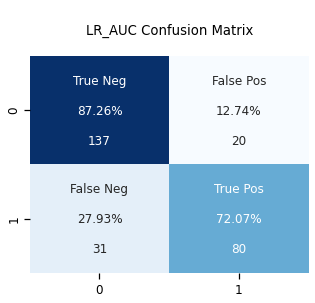

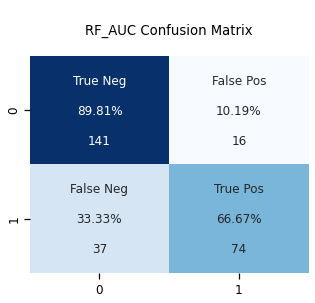

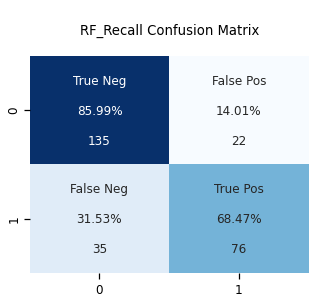

In [29]:
# Plot confusion matrices for all models with test split
for model in models:
    make_cm(model['Name'], model['Model'], test_features, test_labels)

## Compare ROC Curves

Resources: 
- https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot 
- https://stats.stackexchange.com/questions/437358/how-to-plot-multiple-classifiers-roc-curves-using-scikitplot
- https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_22_0.html

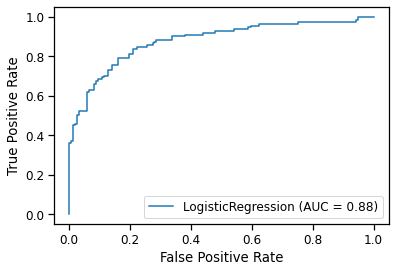

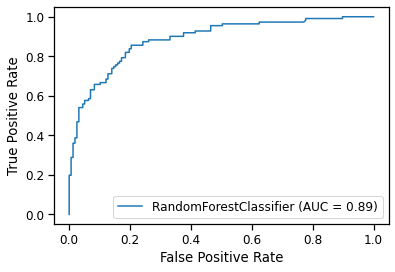

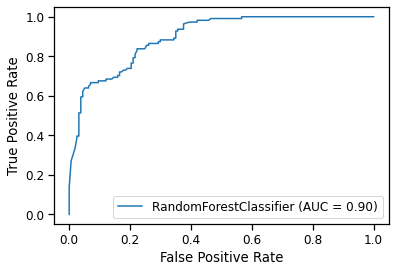

In [30]:
for model in models:
    plot_roc_curve(model['Model'], test_features, test_labels);

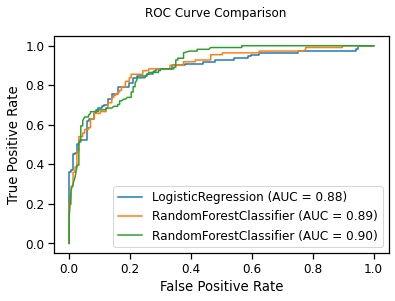

In [31]:
# Plot all together on same chart
# https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_22_0.html
LR_AUC_roc = plot_roc_curve(LR_AUCmodel, test_features, test_labels);
RF_AUC_roc = plot_roc_curve(RF_AUCmodel, test_features, test_labels, ax=LR_AUC_roc.ax_);
RF_Recall_roc = plot_roc_curve(RF_Recallmodel, test_features, test_labels, ax=LR_AUC_roc.ax_);
RF_Recall_roc.figure_.suptitle("ROC Curve Comparison")
plt.show()